This workbook follows the example here: https://huggingface.co/transformers/custom_datasets.html?highlight=sequence#seq-imdb

Can download the data directly from Stanford website with the following two commands:
wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
tar -xf aclImdb_v1.tar.gz

In [1]:
# Imports
import random

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

In [2]:
# Set random seed
seed = random.seed(42)

In [3]:
# Preprocess data in script to create neutral and gendered versions
!python3 preprocess.py -d 'data/aclImdb/train/' -v 'wordlist/' -o 'data/processed_train.csv'
!python3 preprocess.py -d 'data/aclImdb/test/' -v 'wordlist/' -o 'data/processed_test.csv'

Parsing data...
Parsing vocab lists...
Creating vocab mappings...
Processing neutral review dataset...
Processing female gendered review dataset...
Processing male gendered review dataset...
Saved new dataset to /Users/samuelguytemlock/Documents/MIDS/Courses/Fall_2021/W266/final_project/data/processed_train.csv
Parsing data...
Parsing vocab lists...
Creating vocab mappings...
Processing neutral review dataset...
Processing female gendered review dataset...
Processing male gendered review dataset...
Saved new dataset to /Users/samuelguytemlock/Documents/MIDS/Courses/Fall_2021/W266/final_project/data/processed_test.csv


In [4]:
# Read in processed data
df_train = pd.read_csv('data/processed_train.csv')
df_test = pd.read_csv('data/processed_test.csv')
df_train.head()

,review_id,review_score,review_text,neutral_review_text,female_review_text,male_review_text,label
0,4715,9,For a movie that gets no respect there sure ar...,NaN,for a movie that gets no respect there sure ar...,for a movie that gets no respect there sure ar...,1
1,12390,8,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous faces ...,1
2,8329,7,"A solid, if unremarkable film. Matthau, as Ein...",NaN,"a solid, if unremarkable film. matthau, as ein...","a solid, if unremarkable film. matthau, as ein...",1
3,9063,8,It's a strange feeling to sit alone in a theat...,it's a strange feeling to sit alone in a theat...,it's a strange feeling to sit alone in a theat...,it's a strange feeling to sit alone in a theat...,1
4,3092,10,"You probably all already know this by now, but...","you probably all already know this by now, but...","you probably all already know this by now, but...","you probably all already know this by now, but...",1


In [5]:
# Check how many reviews had no replacement tokens
print("Nongendered revies in train:", df_train['neutral_review_text'].isna().sum())
print("Nongendered revies in test:", df_test['neutral_review_text'].isna().sum())

Nongendered revies in train: 4119
Nongendered revies in test: 4172


In [6]:
# Isolate the nongendered reviews 
df_nongendered = df_train[df_train['neutral_review_text'].isna()]

In [7]:
# Check the balance of review scores in the original train set
df_train['review_score'].value_counts()/len(df_train['review_score'])

1     0.20400
10    0.18928
8     0.12036
4     0.10784
7     0.09984
3     0.09680
2     0.09136
9     0.09052
Name: review_score, dtype: float64

In [8]:
# Check the balance of review scores in the nongendered reviews
df_nongendered['review_score'].value_counts()/len(df_nongendered['review_score'])

1     0.251517
10    0.237679
8     0.097354
9     0.092498
2     0.090070
4     0.088128
3     0.079145
7     0.063608
Name: review_score, dtype: float64

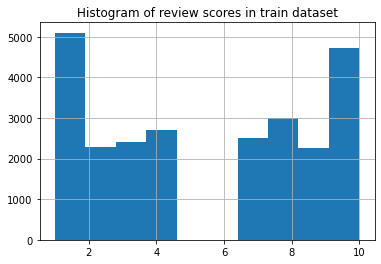

In [9]:
# Check the distribution of the review scores in train
df_train.hist(column='review_score')
plt.title("Histogram of review scores in train dataset")
plt.show()

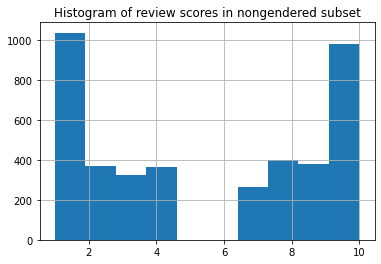

In [10]:
# Check the distribution of the review scores in nongendered reviews
df_nongendered.hist(column='review_score')
plt.title("Histogram of review scores in nongendered subset")
plt.show()

In [11]:
# Drop all nongendered rows in train
df_train.dropna(inplace=True)
print("Number of rows left in train:", df_train.shape[0])
print("Class balance:")
print(df_train['label'].value_counts())

Number of rows left in train: 20881
Class balance:
1    10477
0    10404
Name: label, dtype: int64


In [12]:
# Drop all nongendered rows in test
df_test.dropna(inplace=True)
print("Number of rows left in test:", df_test.shape[0])
print("Class balance:")
print(df_test['label'].value_counts())

Number of rows left in test: 20828
Class balance:
0    10471
1    10357
Name: label, dtype: int64


In [13]:
# Load data
train_texts = df_train['review_text'].values.tolist()
n_train_texts = df_train['neutral_review_text'].values.tolist()
f_train_texts = df_train['female_review_text'].values.tolist()
m_train_texts = df_train['male_review_text'].values.tolist()
train_labels = df_train['label'].values.tolist()

test_texts = df_test['review_text'].values.tolist()
n_test_texts = df_test['neutral_review_text'].values.tolist()
f_test_texts = df_test['female_review_text'].values.tolist()
m_test_texts = df_test['male_review_text'].values.tolist()
test_labels = df_test['label'].values.tolist()

In [14]:
# Create dev set from portion of train set
dev_texts, test_texts, _, _ = train_test_split(test_texts, test_labels, test_size=.5, random_state=seed)
n_dev_texts, n_test_texts, _, _ = train_test_split(n_test_texts, test_labels, test_size=.5, random_state=seed)
f_dev_texts, f_test_texts, _, _ = train_test_split(f_test_texts, test_labels, test_size=.5, random_state=seed)
m_dev_texts, m_test_texts, dev_labels, test_labels = train_test_split(m_test_texts, test_labels, 
                                                                        test_size=.5, random_state=seed)

In [15]:
# Specify tokenizer and apply to each dataset
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [16]:
# Turn encodings into datasets for easy batching
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
dev_dataset = tf.data.Dataset.from_tensor_slices((
    dict(dev_encodings),
    dev_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [ ]:
# # Fine tune with Trainer
# training_args = TFTrainingArguments(
#     output_dir='./results',          # output directory
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=16,  # batch size per device during training
#     per_device_eval_batch_size=64,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_steps=1,
#     eval_steps=500
# )

# with training_args.strategy.scope():
#     model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# trainer = TFTrainer(
#     model=model,                         # the instantiated model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=dev_dataset             # evaluation dataset
# )

# trainer.train()

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss) # can also use any keras loss fn
model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16)

In [ ]:
model.evaluate(dev_dataste.shuffle(1000).batch(16), batch_size=16)

In [ ]:
model.save_model("original_base_model")
tokenizer.save_pretrained("original_tokenizer")